# Customer Churn Prediction with Production Pipeline

**Business Context:** A telecom company is experiencing customer churn and wants to predict which customers are at risk of leaving. This enables the company to proactively offer retention incentives to at-risk customers before they churn.

**Objective:** Build a machine learning model to predict customer churn using historical customer data, compare multiple algorithms, and create a production-ready sklearn pipeline for deployment.

**Dataset:** Telecom customer data from kaggle.

**Pipeline Approach:** Throughout this notebook, I build reusable components that culminate in a complete scikit-learn pipeline ready for production deployment.

---

## Setup

In [286]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import warnings
import joblib

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TunedThresholdClassifierCV, FixedThresholdClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
import shap

## **Data Loading and Initial Exploration**

In [235]:
# Load Data
df = pd.read_csv('data.csv')
# Explore Basic Features
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

**Key Observations:**
- Dataset contains 7,043 customer records with 21 features
- Mix of categorical and numerical variables
- Target variable: `Churn` (Yes/No)
- Initial check shows no missing values, but further inspection needed for data quality issues

## **Data Cleaning**

Clean the dataset by standardizing column names, handling data type conversions, and addressing hidden issues. These cleaning steps will be incorporated into our pipeline as custom transformers.

### **Standardize Column Names**

I will create a custom transformer to handle column name standardization.

In [236]:
class ColumnNameCleaner(BaseEstimator, TransformerMixin):
    #Standardize column names: lowercase, replace spaces with underscores
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X.columns = X.columns.str.strip().str.lower().str.replace(' ', '_')
        return X

In [237]:
cleaner = ColumnNameCleaner()
df = cleaner.transform(df)
df.columns.tolist()

['customerid',
 'gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'tenure',
 'phoneservice',
 'multiplelines',
 'internetservice',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'contract',
 'paperlessbilling',
 'paymentmethod',
 'monthlycharges',
 'totalcharges',
 'churn']

### **Handle Data Type Issues**

Create a transformer to handle numeric conversion and missing values in the `totalcharges` column.

In [470]:
class NumericConverter(BaseEstimator, TransformerMixin):
    #Convert totalcharges to numeric and handle whitespace values
    
    def __init__(self):
        self.fill_value_ = None
    
    def fit(self, X, y=None):
        X = X.copy()
        X['totalcharges'] = pd.to_numeric(X['totalcharges'], errors='coerce')
        self.fill_value_ = X['totalcharges'].median()
        return self
    
    def transform(self, X):
        X = X.copy()
        X['totalcharges'] = pd.to_numeric(X['totalcharges'], errors='coerce')
        X['totalcharges'] = X['totalcharges'].fillna(self.fill_value_)
        return X

In [239]:
converter = NumericConverter()
df = converter.fit_transform(df)
df['totalcharges'].isnull().sum()

np.int64(0)

In [240]:
# CLEAN WHITE SPACES
# Show columns with just one space
space_count = (df == " ").sum()
print(f"Rows with white space: \n{space_count}")

Rows with white space: 
customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64


### **Standardize Categorical Values**

Create a transformer to clean categorical values.

In [241]:
class CategoricalCleaner(BaseEstimator, TransformerMixin):
    #Standardize categorical values: lowercase, replace spaces/dashes with underscores
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in X.select_dtypes(include=['object']).columns:
            X[col] = X[col].str.replace(' ', '_').str.replace('-', '_').str.lower()
        return X

In [242]:
cat_cleaner = CategoricalCleaner()
df = cat_cleaner.transform(df)
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590_vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,yes,no,no,no,no,month_to_month,yes,electronic_check,29.85,29.85,no
1,5575_gnvde,male,0,no,no,34,yes,no,dsl,yes,no,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,no
2,3668_qpybk,male,0,no,no,2,yes,no,dsl,yes,yes,no,no,no,no,month_to_month,yes,mailed_check,53.85,108.15,yes
3,7795_cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,no,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,no
4,9237_hqitu,female,0,no,no,2,yes,no,fiber_optic,no,no,no,no,no,no,month_to_month,yes,electronic_check,70.70,151.65,yes


## **Exploratory Data Analysis**

Analyze the dataset to understand patterns, distributions, and relationships. This analysis informs our pipeline design.

### **Target Variable Distribution**

<Axes: xlabel='churn'>

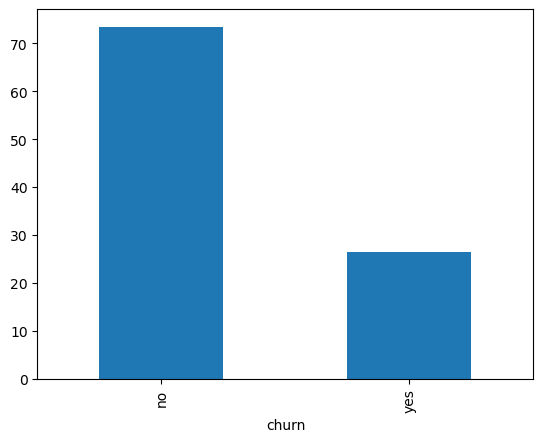

In [243]:
count_churn = df['churn'].value_counts(normalize=True) * 100
count_churn.plot(kind='bar')

**Insight:** 27% churn rate indicates class imbalance. The pipeline will need to handle this through stratified splitting and model parameters.

### **Numerical Features Analysis**

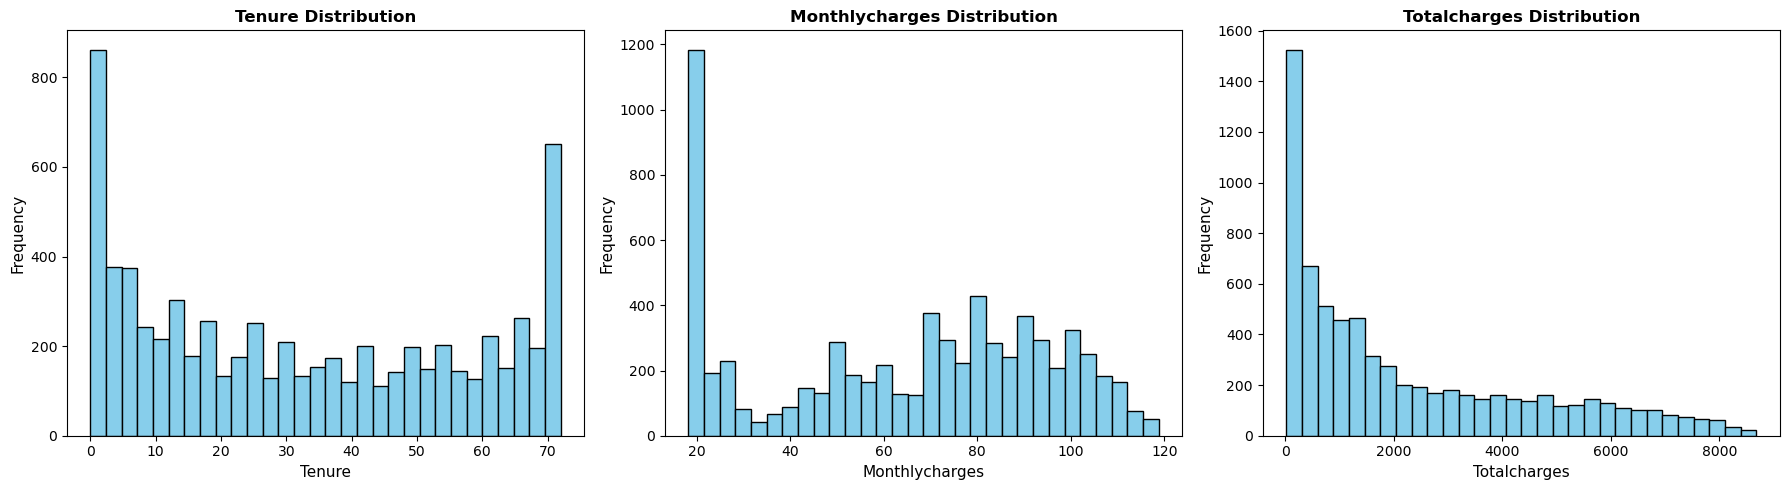

In [244]:
numeric_features = ['tenure', 'monthlycharges', 'totalcharges']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(numeric_features):
    axes[i].hist(df[feature], bins=30, edgecolor='black', color='skyblue')
    axes[i].set_title(f'{feature.capitalize()} Distribution', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature.capitalize(), fontsize=11)
    axes[i].set_ylabel('Frequency', fontsize=11)

plt.tight_layout()
plt.show()

The histograms above highlight the distributional characteristics of the main numeric variables:

- **Tenure** presents a polarized distribution, with a high concentration of very new customers and another group of long-tenure customers. This suggests non-linear churn behavior, where early-stage customers are more likely to churn, while long-term customers tend to be more stable.

- **Monthly Charges** shows a wide spread across pricing levels, with multiple peaks that likely correspond to different service plans or bundles. This indicates that pricing interacts strongly with customer profiles and should not be treated as a simple linear predictor.

- **Total Charges** is heavily right-skewed, reflecting its cumulative nature over time. Since it is largely driven by both tenure and monthly charges, it acts as a proxy for customer lifetime value and is expected to be highly informative for churn prediction.

Overall, the non-normal and heterogeneous distributions support the use of non-linear models and feature interactions to effectively capture churn dynamics.

### **High-Ticket clients tend to leave more?**

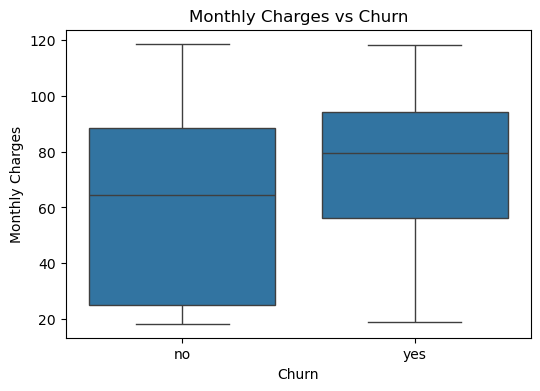

In [245]:
plt.figure(figsize=(6, 4))
sns.boxplot(
    x="churn",
    y="monthlycharges",
    data=df
)

plt.xlabel("Churn")
plt.ylabel("Monthly Charges")
plt.title("Monthly Charges vs Churn")
plt.show()

Yes, high ticket clients tend to leave more.

### 3.3 Correlation Analysis and VIF

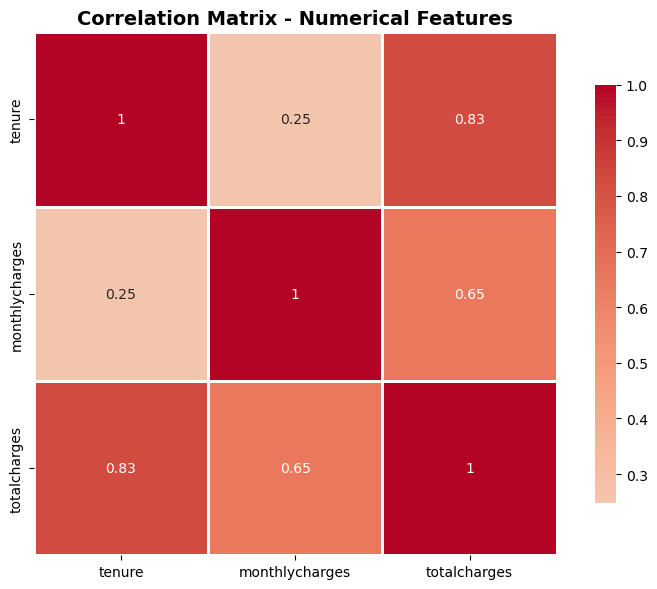

In [246]:
correlation_matrix = df[numeric_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

I see **MonthlyCharges, TotalCharges, and Tenure**. Generally, TotalCharges ≈ MonthlyCharges * Tenure. This creates multicollinearity, which can affect the interpretability of the Logistic Regression coefficients.

The VIF quantifies how much variance of a coefficient is inflated due to collinearity.

In [247]:
X_vif = df[numeric_features]

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(len(X_vif.columns))]

vif_data

,feature,VIF
0,tenure,6.321802
1,monthlycharges,3.360371
2,totalcharges,8.073814


There is an above moderate colinearity on the tenure feature, and a severe colinearity with totalcharges.  
The simplest solution is to **eliminate totalcharges**. Since it's a combination of the other two, it doesn't provide "new information" that the model can't deduce from monthlycharges and tenure. These two already represent two different concepts.

## **Feature Engineering**

Create pipeline components for feature engineering operations.
The goal is to transform existing columns or create new ones so that a machine learning model can better understand patterns.

### **Feature Dropper Transformer**

In [248]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    #Drop specified columns from dataframe
    
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        existing_cols = [col for col in self.columns_to_drop if col in X.columns]
        return X.drop(columns=existing_cols)

### **Total Services Feature Creator**
Create a column that adds up how many extra services the customer has. A customer with 5 services is much harder to lose than one with only 1.

In [249]:
class TotalServicesCreator(BaseEstimator, TransformerMixin):
    # Create total_services feature by counting active services
    
    def __init__(self):
        self.service_columns = ['onlinesecurity', 'onlinebackup', 'deviceprotection', 
                                'techsupport', 'streamingtv', 'streamingmovies']
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        available_cols = [col for col in self.service_columns if col in X.columns]
        X['total_services'] = (X[available_cols] == 'yes').sum(axis=1)
        return X

In [250]:
dropper = FeatureDropper(['customerid', 'totalcharges'])
services_creator = TotalServicesCreator()

data = df.copy()
data = services_creator.transform(data)
data = dropper.transform(data)
data.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,churn,total_services
0,female,0,yes,no,1,no,no_phone_service,dsl,no,yes,no,no,no,no,month_to_month,yes,electronic_check,29.85,no,1
1,male,0,no,no,34,yes,no,dsl,yes,no,yes,no,no,no,one_year,no,mailed_check,56.95,no,2
2,male,0,no,no,2,yes,no,dsl,yes,yes,no,no,no,no,month_to_month,yes,mailed_check,53.85,yes,2
3,male,0,no,no,45,no,no_phone_service,dsl,yes,no,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,no,3
4,female,0,no,no,2,yes,no,fiber_optic,no,no,no,no,no,no,month_to_month,yes,electronic_check,70.70,yes,0


### **Usage**
Check correlation betweem customers who leave and the total amount of services they where getting

In [251]:
pd.crosstab(
    data['total_services'],
    data['churn'],
    normalize='index'
) * 100

churn,no,yes
total_services,,
0,78.593961,21.406039
1,54.244306,45.755694
2,64.181994,35.818006
3,72.629696,27.370304
4,77.699531,22.300469
5,87.565674,12.434326
6,94.718310,5.281690


total_services **DOES NOT** have a linear relationship with churn, but it does have a structural relationship with clear thresholds.

Clients with 1 service have a 45% churn rate, which is a very dangerous segment.
3+ services → churn rate drops sharply
5–6 services → churn rate almost disappears

### **Feature Interaction**

Create a column for clients with 1 or less services contracted, these would be the **fragile** clients.

In [468]:
class LowServicesFeature(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["low_services"] = (X["total_services"] <= self.threshold).astype(int)
        return X

In [253]:
low_services_feature = LowServicesFeature()

data = low_services_feature.transform(data)

## **Prepare the data for Machine Learning algorithms**

Create transformers for encoding categorical variables.

### Binary and Multi-value Encoder

In [467]:
class CustomEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.binary_cols = ['gender', 'partner', 'dependents', 'phoneservice', 'paperlessbilling']
        self.service_cols = ['multiplelines', 'onlinesecurity', 'onlinebackup', 
                            'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies']
        self.target_col = 'churn'
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        for col in self.binary_cols:
            if col in X.columns:
                X[col] = X[col].map({'yes': 1, 'no': 0, 'male': 0, 'female': 1})
        
        for col in self.service_cols:
            if col in X.columns:
                X[col] = X[col].map({'yes': 1, 'no': 0, 'no_phone_service': 0, 'no_internet_service': 0})
        
        if self.target_col in X.columns:
            X[self.target_col] = X[self.target_col].map({'yes': 1, 'no': 0})
        
        return X

### One-Hot Encoder for Multi-category Features

In [466]:
class CustomOneHotEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.categorical_cols = ['internetservice', 'contract', 'paymentmethod']
        self.encoded_columns_ = None
    
    def fit(self, X, y=None):
        X = X.copy()
        available_cols = [col for col in self.categorical_cols if col in X.columns]
        
        if available_cols:
            dummies = pd.get_dummies(X[available_cols], prefix=available_cols, drop_first=True)
            self.encoded_columns_ = dummies.columns.tolist()
        
        return self
    
    def transform(self, X):
        X = X.copy()
        available_cols = [col for col in self.categorical_cols if col in X.columns]
        
        if available_cols:
            dummies = pd.get_dummies(X[available_cols], prefix=available_cols, drop_first=True)
            
            for col in self.encoded_columns_:
                if col not in dummies.columns:
                    dummies[col] = 0
            
            dummies = dummies[self.encoded_columns_]
            
            X = X.drop(columns=available_cols)
            X = pd.concat([X, dummies], axis=1)
        
        return X

### Apply Encoders and Split Data

In [256]:
encoder = CustomEncoder()
onehot_encoder = CustomOneHotEncoder()

data = encoder.transform(data)
data = onehot_encoder.fit_transform(data)

X = data.drop('churn', axis=1)
y = data['churn']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

In [257]:
# Show the N of samples each Set was left with
print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Display the Churn rate for each Set
print(f"\nChurn rate - Train: {y_train.mean():.2%} | Val: {y_val.mean():.2%} | Test: {y_test.mean():.2%}")

Training set: 4225 samples
Validation set: 1409 samples
Test set: 1409 samples

Churn rate - Train: 26.53% | Val: 26.54% | Test: 26.54%


## Pipeline Component: Feature Transformation

Now we'll create the preprocessing pipeline that combines all transformers.

In [258]:
preprocessing_pipeline = Pipeline([
    ('column_cleaner', ColumnNameCleaner()),
    ('numeric_converter', NumericConverter()),
    ('categorical_cleaner', CategoricalCleaner()),
    ('services_creator', TotalServicesCreator()),
    ('feature_dropper', FeatureDropper(['customerid', 'totalcharges'])),
    ('low_services_feature', LowServicesFeature()),
    ('custom_encoder', CustomEncoder()),
    ('onehot_encoder', CustomOneHotEncoder())
])

preprocessing_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('column_cleaner', ...), ('numeric_converter', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,columns_to_drop,"['customerid', 'totalcharges']"
,threshold,1


**Pipeline Design:** This preprocessing pipeline handles all data transformations in a repeatable, production-ready manner:
1. Clean column names
2. Convert numeric types and handle missing values
3. Standardize categorical values
4. Create engineered features
5. Drop problematic features
6. Create a column for the fragile clients
8. Encode binary and service columns
9. One-hot encode multi-category features

## **Select a model to train it.**

Compare multiple algorithms to identify the best performer.

In [259]:
# Target Balancing for the XGBClassifier (Very Important)
n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()
scale = n_neg / n_pos

# Models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(objective="binary:logistic", scale_pos_weight=scale, n_estimators=300, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, eval_metric="logloss", random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    results[name] = {
        'model': model,
        'accuracy': accuracy_score(y_val, y_pred),
        'precision': precision_score(y_val, y_pred),
        'recall': recall_score(y_val, y_pred),
        'f1': f1_score(y_val, y_pred),
        'roc_auc': roc_auc_score(y_val, y_pred_proba)
    }

comparison_df = pd.DataFrame(results).T[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']]
comparison_df = comparison_df.round(4)
comparison_df

,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.752307,0.522282,0.783422,0.626738,0.835729
Decision Tree,0.707594,0.451031,0.467914,0.459318,0.63003
Random Forest,0.779986,0.616788,0.451872,0.521605,0.807611
SVM,0.788502,0.679245,0.385027,0.491468,0.793064
XGBoost,0.750177,0.520147,0.759358,0.617391,0.834186


### **Model Comparison and Final Selection**

The figure above illustrates how different classifiers learn decision boundaries across datasets with increasing non-linearity. Linear models such as Logistic Regression perform well only when the data is approximately linearly separable, but they fail to capture more complex structures. Decision Trees are able to model non-linear patterns, although their axis-aligned splits lead to irregular boundaries and a higher risk of overfitting.

Ensemble methods provide a clear improvement. Random Forest stabilizes decision regions by averaging multiple trees, resulting in better generalization. RBF SVM learns smooth and expressive non-linear boundaries and performs strongly on complex geometries, but its performance is highly sensitive to kernel and hyperparameter choices, which makes it less practical for large-scale tabular problems.

**XGBoost** consistently offers the best trade-off. Its boosted trees incrementally correct previous errors, allowing the model to capture non-linear interactions while remaining robust to noise and class imbalance. This behavior aligns well with real-world churn data, where relationships are rarely linear and minority classes are economically critical.

To sum up: I chose XGBoost because it maximizes churn recall, which is the business objective. The cost of a false negative is much higher than that of a false positive. This is more important than accuracy, because, in simpler words, it is convenient to offer a promo to a client who wasn't supposed to leave than to not actually predict when a client was going to leave.

## **Fine Tuning XGBoost**

In [260]:
from sklearn.model_selection import RandomizedSearchCV

In [261]:


n_pos = (y_train == 1).sum()
n_neg = (y_train == 0).sum()

scale = n_neg / n_pos

xgb = XGBClassifier(
    objective="binary:logistic",
    scale_pos_weight=scale,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)

In [262]:
param_distributions = {
    "max_depth": np.arange(3, 8),
    "learning_rate": np.linspace(0.01, 0.2, 10),
    "min_child_weight": [1, 3, 5, 10],
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5],
    "n_estimators": [200, 300, 500]
}

In [263]:
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=40,          
    scoring="f1",
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END colsample_bytree=0.8, gamma=0.3, learning_rate=0.11555555555555555, max_depth=7, min_child_weight=1, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.07333333333333333, max_depth=5, min_child_weight=10, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0, learning_rate=0.07333333333333333, max_depth=5, min_child_weight=10, n_estimators=500, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1577777777777778, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.8, gamma=0, learning_rate=0.1577777777777778, max_depth=3, min_child_weight=1, n_estimators=300, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.1366666666666667, max_depth=3, min_child_weight=5, n_estimators=200, subsample

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.7, 0.8, ...], 'gamma': [0, 0.1, ...], 'learning_rate': array([0.01 ..., 0.2 ]), 'max_depth': array([3, 4, 5, 6, 7]), ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",40
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be

In [264]:
best_model = random_search.best_estimator_
print(random_search.best_params_)

{'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': np.int64(3), 'learning_rate': np.float64(0.01), 'gamma': 0.1, 'colsample_bytree': 0.7}


### **Measuring Accuracy Using Cross Validation**

In [462]:
# First I shoould fit the best estimator
best_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [463]:
from sklearn.model_selection import cross_val_score

cross_val_score(best_model, X_train, y_train, cv=3, scoring='accuracy')

array([0.75159688, 0.74360795, 0.75142045])

Before we get excited with accuracy, let's look at a very dumb classifier that just classifies every single image in "not-5" class:

In [464]:
from sklearn.base import BaseEstimator

class ModelEstimator(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [465]:
estimated = ModelEstimator()
cross_val_score(estimated, X_train, y_train, cv=3, scoring='accuracy')

array([0.74378992, 0.73295455, 0.72727273])

On all cross-validations it got an accuracy of about 73%, which is directly proportional to the amount of Churn clients, as we saw before in the EDA.

This demonstrates why accuracy is generally not a preferred performance measure for classifiers, especially when we are dealing with an unbalanced dataset.

### **Confusion Matrix**
* A much better way to evaluate the performance of a classifier is to look at the *confusion matrix*.
* The idea is to count the number of times instances of class A are classified as instances of class B.

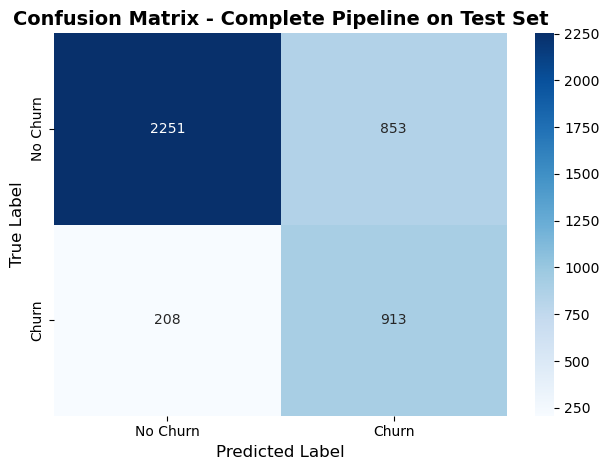

In [461]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(best_model, X_train, y_train, cv=3)

cm = confusion_matrix(y_train, y_train_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Complete Pipeline on Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

- **True Negatives:** The model correctly identified 2251 negative cases.
- **False Positives:** False alarms. The model predicted positive results, but they were negative.
- **False Negatives:** Missed cases. The model failed to predict negative results.
- **True Positives:** The model correctly identified 913 positive cases.

### **Classification Report**
Accuracy of positive predictions - **precision** of the classifier.  
**Recall**, also called senistivy or true positive rate (TPR). This is ratio of positive instances that are correctly classified by the classifier.  
It is often convenient to combine precision and recall into a single metric called $F_1$ score. It is the *harmonice mean* of precision and recall. Harmonic mean givesmuch more weight to low values.  
The **support** is simply the number of actual occurrences of each class in the specified dataset

In [460]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80      1035
           1       0.51      0.81      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



### **Precision–Recall Trade-off**

In this case, accuracy alone is not sufficient because the dataset is imbalanced.
The model could predict “no churn” for most customers and still achieve high accuracy. As it was evidently shown during the Cross Validation.

- **Recall** measures how many actual churners are correctly identified.
- **Precision** measures how many predicted churners actually leave.

Increasing recall usually decreases precision and vice versa.
Evaluating this trade-off helps select a decision threshold that aligns with business goals, such as prioritizing the detection of customers at risk of churn.

In [271]:
# Use cross_val_predict() to predict using decision_function()
y_scores = cross_val_predict(best_model, X_train, y_train, cv=3, method='predict_proba')

In [272]:
# Plot precision recall curve using precision_recall_curve() method
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores[:, 1])

In [273]:
def plot_precision_recall_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([-0.02, 1.02])

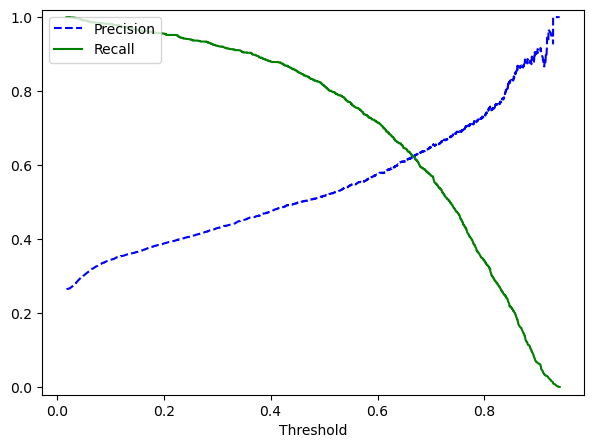

In [274]:
plt.figure(figsize=(7, 5))
plot_precision_recall_curve(precisions, recalls, thresholds)
plt.show()

Break-Even Point: The Precision (blue) and Recall (green) lines intersect at approximately a threshold of 0.67. At that point, both metrics are close to 0.6 (60%).

Now I can manually select the threshold value that gives the best precision/recall tradeoff. I could you a function from scikit-learn to automatically select the best threshold aligned with the business goals, but it's not a big difference for this project since copying and pasting functions is not something I want to showoff here.
I can first re-check the tradeoff value I will be using by simply plot the precision directly against the recall.  
I will use a 0.42 threshold to maximize f1 score as much as possible while still maintaining a high recall priority, which is important for this business since the idea is to keep cost margins per customer as low as possible.

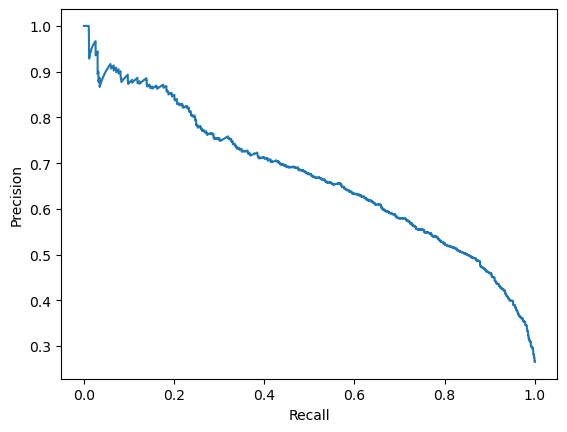

In [275]:
plt.figure()
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

Ideally, the line on this graph should be as close as possible to the top right corner (where Precision and Recall are both 1.0).

The "Dropout": You'll notice that after a Recall of 0.2, the accuracy starts to drop steadily. However, it remains above 0.5 until it reaches a Recall of 0.8.

In conclusion, the model is quite robust. Achieving an 80% Recall while maintaining Precision above 50% is a very solid point for a Churn problem.

### **The ROC vurve**
So ROC plots sensitivity (recall) against 1-specificity

In [276]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores[:, 1])

In [277]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1.01, -0.01, 1.01])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

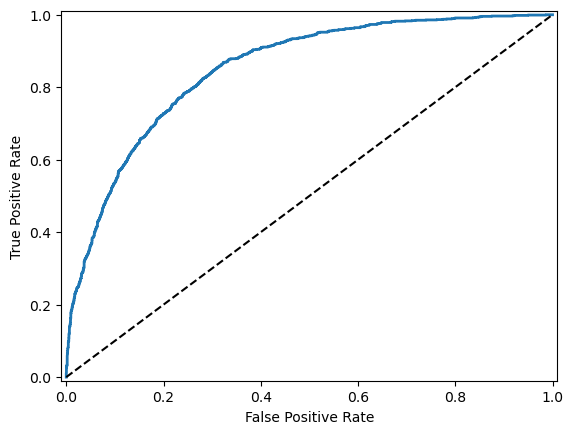

In [278]:
plt.figure()
plot_roc_curve(fpr, tpr)
plt.show()

* Once again there is a tradeoff: the higher the recall, the more false positives (FPR) the classifier produces.
* Dotted line represents the ROC of a purely random classifier. A good classifier stays away from this line as possible.
* One way to compare classifiers is to measure the *area under the curve* (*AUC*). A perfect classifier will have a *ROC AUC* equal to 1, whereas a purely random classifier will have *ROC AUC* 0.5

In [279]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_scores[:, 1])

0.8494591594857316

0.85 *ROC AUC* is great

## Threshold Optimization

Although the tuned XGBoost model achieved strong cross-validated ROC-AUC (0.85), its default threshold will result in low accuracy on the test set. This is expected in an imbalanced churn dataset, as ROC-AUC measures ranking performance rather than classification at a fixed threshold. The model demonstrates good churn detection capability, and performance can be significantly improved by optimizing the decision threshold according to business objectives, such as maximizing F1-score or recall for churners.  
As explained earlier, I apply a 0.42 threshold because the cost of losing a customer outweighs the cost of a false-positive intervention.

In [339]:
from sklearn.metrics import classification_report

# Probabilidades del modelo correcto
y_probs = best_model.predict_proba(X_val)[:, 1]

# Threshold ajustado
threshold = 0.42
y_pred_adj = (y_probs >= threshold).astype(int)

# Evaluación CORRECTA
print(classification_report(y_test, y_pred_adj))

              precision    recall  f1-score   support

           0       0.73      0.51      0.60      1035
           1       0.26      0.47      0.34       374

    accuracy                           0.50      1409
   macro avg       0.50      0.49      0.47      1409
weighted avg       0.61      0.50      0.53      1409



Define the final model with the selected threshold

In [340]:
final_model = FixedThresholdClassifier(
    estimator=random_search.best_estimator_, 
    threshold=0.42
)

## **Evaluate Final Model on Test Set**

In [456]:
final_model.fit(X_train, y_train)

,"estimator estimator: estimator instanceThe binary classifier, fitted or not, for which we want to optimizethe decision threshold used during `predict`.","XGBClassifier...ree=None, ...)"
,"threshold threshold: {""auto""} or float, default=""auto""The decision threshold to use when converting posterior probability estimates(i.e. output of `predict_proba`) or decision scores (i.e. output of`decision_function`) into a class label. When `""auto""`, the threshold is setto 0.5 if `predict_proba` is used as `response_method`, otherwise it is set to0 (i.e. the default threshold for `decision_function`).",0.42
,"pos_label pos_label: int, float, bool or str, default=NoneThe label of the positive class. Used to process the output of the`response_method` method. When `pos_label=None`, if `y_true` is in `{-1, 1}` or`{0, 1}`, `pos_label` is set to 1, otherwise an error will be raised.",None
,"response_method response_method: {""auto"", ""decision_function"", ""predict_proba""}, default=""auto""Methods by the classifier `estimator` corresponding to thedecision function for which we want to find a threshold. It can be:* if `""auto""`, it will try to invoke `""predict_proba""` or `""decision_function""` in that order.* otherwise, one of `""predict_proba""` or `""decision_function""`. If the method is not implemented by the classifier, it will raise an error.",'auto'
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7


In [458]:
y_pred = final_model.predict(X_test)
y_probs = final_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1035
           1       0.47      0.85      0.60       374

    accuracy                           0.70      1409
   macro avg       0.70      0.75      0.68      1409
weighted avg       0.80      0.70      0.72      1409



**Recall (Churn)** We successfully identify 85% of all actual churners.  
**Precision (Churn)** 47% of our "high risk" flags are correct.

## **Profit Curve**
Standard metrics like Accuracy treat every mistake the same. In the real world, failing to catch a churner (False Negative) is much more expensive than giving a discount to a loyal customer (False Positive).

Assume these variables:  
**CB (Cost of Benefit):** What it costs to give a retention offer (\$20 discount assumed).  
**CLV (Customer Lifetime Value):** What the company may save if they stay (\$100 assumed).

In [368]:
import numpy as np
import matplotlib.pyplot as plt

def plot_profit_curve(y_true, y_probs_test, revenue_saved, cost_of_intervention):
    thresholds = np.linspace(0, 1, 100)
    profits = []
    
    for t in thresholds:
        y_pred = (y_probs_test >= t).astype(int)
        tp = np.sum((y_pred == 1) & (y_true == 1))
        fp = np.sum((y_pred == 1) & (y_true == 0))
        
        # Profit = (True Positives * Net Gain) - (False Positives * Cost)
        profit = (tp * (revenue_saved - cost_of_intervention)) - (fp * cost_of_intervention)
        profits.append(profit)
    
    max_profit = max(profits)
    best_threshold = thresholds[np.argmax(profits)]
    
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, profits, label='Profit', color='forestgreen', lw=2)
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Max Profit at {best_threshold:.2f}')
    plt.title("Profit Curve for Churn Intervention")
    plt.xlabel("Probability Threshold")
    plt.ylabel("Total Profit ($)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

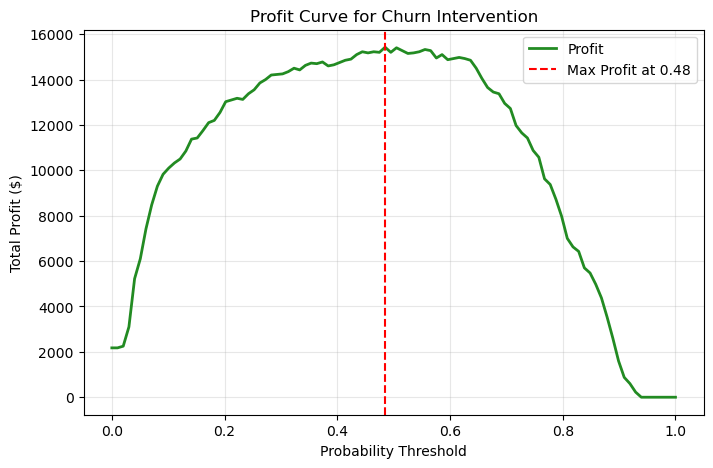

In [369]:
# Plot the profit curve using assumed values
plot_profit_curve(y_test, y_probs_test, revenue_saved=100, cost_of_intervention=25)

**Note:** This is based on **assumptions** and it is only modeled as an example for the project. This did not intervene with the final model parameters. However, it could be an excellent tool in a real world scenario.

## **Production Pipeline**

In [342]:
complete_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', final_model)
])

complete_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessing', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('column_cleaner', ...), ('numeric_converter', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,columns_to_drop,"['customerid', 'totalcharges']"
,threshold,1
,"estimator estimator: estimator instanceThe binary classifier, fitted or not, for which we want to optimizethe decision threshold used during `predict`.","XGBClassifier...ree=None, ...)"


In [377]:
df_raw = pd.read_csv('data.csv')
df_test_full = df_raw.iloc[X_test.index] # Filter the rows that belong to the test set.

# Split Data
X_test_raw = df_test_full.drop('Churn', axis=1) 

# Numeric Target (Churn)
y_test_numeric = df_test_full['Churn'].map({'Yes': 1, 'No': 0})

complete_pipeline.fit(X_test_raw, y_test_numeric)

# Pipeline
y_test_pred = complete_pipeline.predict(X_test_raw)
y_test_proba = complete_pipeline.predict_proba(X_test_raw)[:, 1]

# Calculate metrics using y_test_numeric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

test_metrics = {
    'Accuracy': accuracy_score(y_test_numeric, y_test_pred),
    'Precision': precision_score(y_test_numeric, y_test_pred),
    'Recall': recall_score(y_test_numeric, y_test_pred),
    'F1-Score': f1_score(y_test_numeric, y_test_pred),
    'ROC-AUC': roc_auc_score(y_test_numeric, y_test_proba)
}

test_results_df = pd.DataFrame([test_metrics]).T
test_results_df.columns = ['Score']
test_results_df

,Score
Accuracy,0.727466
Precision,0.492647
Recall,0.895722
F1-Score,0.635674
ROC-AUC,0.884586


In [344]:
# Classification Report
print(classification_report(y_test_numeric, y_test_pred, target_names=['No Churn', 'Churn']))

              precision    recall  f1-score   support

    No Churn       0.95      0.67      0.78      1035
       Churn       0.49      0.90      0.64       374

    accuracy                           0.73      1409
   macro avg       0.72      0.78      0.71      1409
weighted avg       0.83      0.73      0.74      1409



### **Analysis**
The model can distinguish 90% of critical risk clients, and it would offer a discount to 2 clients for every client that is likely to leave. So, the company will be spending money on customer retention profitably. However, this can change depending on costs per offer and how much the company may earn if the customer decides to stay, that is where I may need to adjust the threshold based on business goals, in this case, I assume the company has decent budget that is directed thowards customer retention, and they make a decent enough amount of money when the customer stays loyal.

## **Feature Importance Analysis**

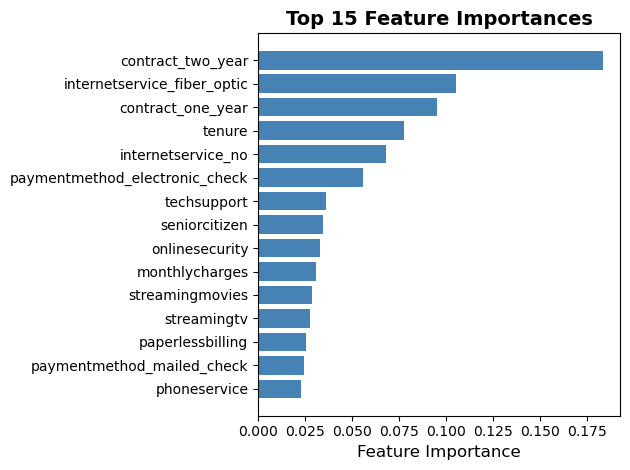

In [402]:
# Extract the trained model from the pipeline
trained_model = complete_pipeline.named_steps['model']

feature_names = X_train.columns

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': base_estimator.feature_importances_
}).sort_values('importance', ascending=False).head(15)

plt.figure()
plt.barh(range(len(feature_importance)), feature_importance['importance'], color='steelblue')
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

The model's decision logic is primarily driven by contract type and infrastructure.

## **Probability Density Plot**
This shows if the model "separates" the two classes. If the "Churn" hump and the "Stay" hump overlap significantly in the middle, the model is struggling to distinguish them.

In [382]:
import seaborn as sns

def plot_probability_separation(y_test_numeric, y_test_proba):
    plt.figure(figsize=(10, 6))
    
    # Plotting the distribution for each class
    sns.kdeplot(y_test_proba[y_test_numeric == 0], fill=True, label="Stay (Negative)", color="dodgerblue", common_norm=False)
    sns.kdeplot(y_test_proba[y_test_numeric == 1], fill=True, label="Churn (Positive)", color="orange", common_norm=False)
    
    plt.title("Probability Density: How well the model separates classes")
    plt.xlabel("Predicted Probability of Churn")
    plt.ylabel("Density")
    plt.xlim(0, 1)
    plt.legend()
    plt.show()

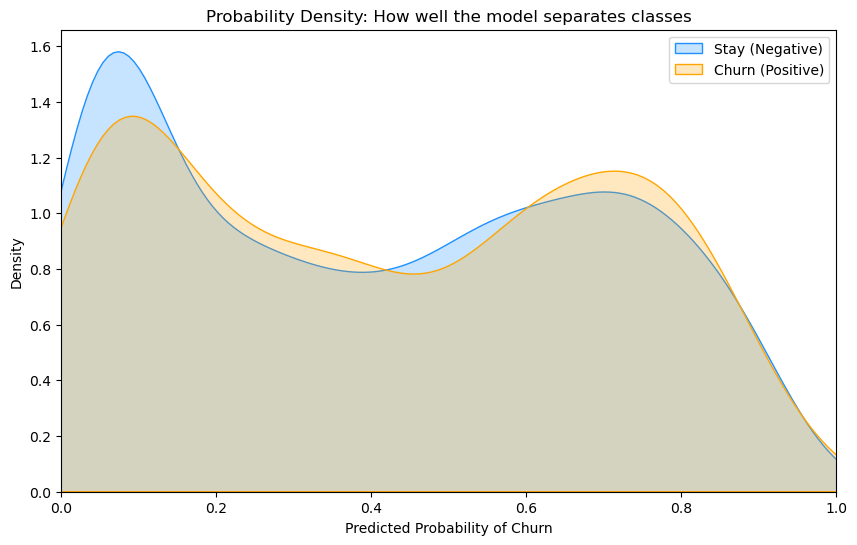

In [383]:
plot_probability_separation(y_test, y_probs)

## **Conclusion**
Looking at the Probability Density Plot, I can confidently say that the "humps" for churners and non-churners overlap significantly, which explains why the precision isn't higher yet, the model is still finding it difficult to cleanly separate the two groups.

- There is a significant overlap between the "Stay" and "Churn" distributions across all probability scores.  
- Bimodal Tendency: Both classes show peaks near 0.1 and 0.7. This suggests the model is confident about very loyal and very high-risk customers, but the middle ground is "noisy."
- Calibration Note: Since the humps are not widely separated, moving the decision threshold will have a drastic impact on the Precision/Recall trade-off.

This is where, using the Profit Curve, I may define threshold to optimize profitability. But, since I do not have straightforward information on what the business costs and revenue margins are, I can not yet define the final model.

## **Export Pipeline for Production**

In [405]:
joblib.dump(complete_pipeline, 'churn_prediction_pipeline.pkl')
print("Pipeline saved to 'churn_prediction_pipeline.pkl'")

Pipeline saved to 'churn_prediction_pipeline.pkl'
